# Connected Components Tutorial - Digital Porous Media


## Overview
This Jupyter Notebook is designed to perform **connected component analysis** on a given dataset or image. Connected component analysis is a common technique in image processing and graph theory used to identify and label connected regions in a binary or labeled image.

Here, we will be using the [connected-components-3d](https://github.com/seung-lab/connected-components-3d) package. More functionality and description about the model is avaiable in the corresponding repository.

*<span style="color:gray;">Silversmith, W. (2021). cc3d: Connected components on multilabel 3D & 2D images. (Version 3.2.1) [Computer software]. ht<span>tps:</span>//doi.<span>or</span>g/ht<span>tps</span>://zenodo.org/record/5535251.</span>*

## Purpose
This notebook:
1. Processes input data (e.g., binary porous media images).
2. Identifies connected components in the data.
3. Visualizes or outputs the results of the analysis.

___
*Author/Contact:* ***[Çınar Turhan](https://www.linkedin.com/in/cinarturhan/)*** 

In [1]:
import cc3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import tifffile
import dpm_tools as dpm


# We define a function to plot the pores within the 3D image.
def plot_sample(sample):
    plotter_obj = pv.Plotter(lighting='three lights')

    # Set background colors
    plotter_obj.set_background(color='w')

    # Set font colors and sizes
    pv.global_theme.font.color = 'black'
    pv.global_theme.font.size = 18
    pv.global_theme.font.label_size = 14
    
    pv.set_jupyter_backend('server')
    
    sample = np.pad(sample, ((1, 1), (1, 1), (1, 1)), mode='constant', constant_values=0)
    
    pv_image_obj = pv.wrap(sample)
    contours = pv_image_obj.contour(isosurfaces=[0.5])
    plotter_obj.add_mesh(contours, opacity=1, color=(200 / 255, 181 / 255, 152 / 255), diffuse=0.75, ambient=0.15)
    
    
    plotter_obj.show(jupyter_backend='server')

Original Porosity: 20.61 %
Subset Porosity: 20.52 %
Competent Subset: [50:150,50:150, 50:150]


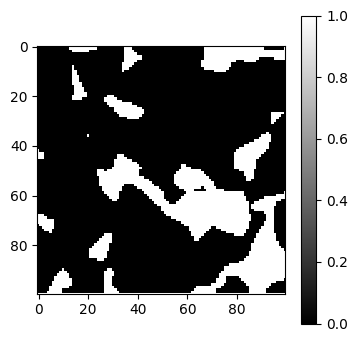

In [2]:
# Load the data:
sample = tifffile.imread('castlegate.tif')

# seting the seed for getting the same competent subset each time:
np.random.seed(42025)

# getting a subset of the data:
subset,_ = dpm.visualization.extract_competent_subset(sample, cube_size= 100, batch=100, pore_class = 1)
sample_subset = sample[subset[0]: subset[1], subset[0]: subset[1], subset[0]: subset[1]]

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
im=plt.imshow(sample_subset[20, :, :], interpolation='none',cmap='gray')
plt.colorbar(im)
plt.show()

In [3]:
plot_sample(sample_subset)

Widget(value='<iframe src="http://localhost:40977/index.html?ui=P_0x7f0be0e8c950_0&reconnect=auto" class="pyvi…

### Extracting Connected Components

To identify and analyze connected components within the 3D image, we utilize the functionality provided by the `connected-components-3d` library. Specifically, we use the `largest_k` function to extract the largest connected components from the `sample_subset` data.

1. **Largest Component (`k=1`)**:
    Using the following script, we extract the largest connected component in the dataset:
    ```python
    largest_comp, N_1 = cc3d.largest_k(
         sample_subset, k=1, 
         connectivity=26, delta=0,
         return_N=True,
    )
    ```
    Here:
    - `k=1` specifies that we want the single largest component.
    - `connectivity=26` ensures that all 26 neighbors in a 3D grid are considered for connectivity.
    - `delta=0` indicates no additional padding or tolerance for connectivity.
    - `return_N=True` returns the total number of connected components found.

2. **Top 10 Largest Components (`k=10`)**:
    To extract the 10 largest connected components, we use:
    ```python
    largest_10_comp, N_10 = cc3d.largest_k(
         sample_subset, k=10, 
         connectivity=26, delta=0,
         return_N=True,
    )
    ```
    This script works similarly to the first one but retrieves the top 10 largest components instead of just one.

These scripts allow us to isolate and analyze the most significant connected regions within the 3D image. We are usually interested in the pore space; therefore, the aim is to extract the largest connected pores.

In [4]:
# return the largest component:
largest_comp, N_1 = cc3d.largest_k(
    sample_subset, k=1, 
    connectivity=26, delta=0,
    return_N=True,
)

# return 10 largest components:
largest_10_comp, N_10 = cc3d.largest_k(
    sample_subset, k=10, 
    connectivity=26, delta=0,
    return_N=True,
)

print(f'Number of components in k=1: {N_1}')
print(f'Number of components in k=10: {N_10}')

Number of components in k=1: 1
Number of components in k=10: 10


To further analyze the connected components, we can use the following code snippets:

1. **Print Unique Labels**:
    ```python
    print(np.unique(largest_comp))
    print(np.unique(largest_10_comp))
    ```
    These lines print the unique labels present in the arrays `largest_comp` and `largest_10_comp`. This helps verify the number of connected components identified and their corresponding labels.


2. **Check Pixel Values for Each Label**:
    ```python
    df = pd.DataFrame(np.unique(largest_10_comp, return_counts=True))
    df.columns = ['background'] + [f'comp{i}' for i in range(1, df.shape[1])]
    df.index = ['label', 'count']
    df = df.T
    df
    ```
    This snippet allows us to check the pixel counts associated with each label in `largest_10_comp`. By examining these values, we can determine which component is the largest one based on the count of pixels for each label.

In [5]:
print(np.unique(largest_comp))
print(np.unique(largest_10_comp))


df = pd.DataFrame(np.unique(largest_10_comp, return_counts=True))
df.columns = ['background'] + [f'comp{i}' for i in range(1, df.shape[1])]
df.index = ['label', 'count']
df = df.T
df

[0 1]
[ 0  1  2  3  4  5  6  7  8  9 10]


,label,count
background,0,794967
comp1,1,37
comp2,2,43
comp3,3,56
comp4,4,57
comp5,5,107
comp6,6,176
comp7,7,679
comp8,8,1229
comp9,9,2004


In [6]:
# Sort the DataFrame by count in descending order and pick the largest and second largest components
sorted_df = df.iloc[1:].sort_values(by='count', ascending=False)  # Exclude 'background'
largest_label = sorted_df['label'][0]
second_largest_label = sorted_df['label'][1]

print(f"In this case, label {largest_label} is the largest component, and label {second_largest_label} is the second largest component. Let's isolate and visualize each.")

In this case, label 10 is the largest component, and label 9 is the second largest component. Let's isolate and visualize each.


In [7]:
extracted_largest_component_image = largest_10_comp * (largest_10_comp == largest_label)
extracted_second_largest_component_image = largest_10_comp * (largest_10_comp == second_largest_label)

plot_sample(extracted_largest_component_image)
plot_sample(extracted_second_largest_component_image)

Widget(value='<iframe src="http://localhost:40977/index.html?ui=P_0x7f0be0c28fd0_1&reconnect=auto" class="pyvi…

Widget(value='<iframe src="http://localhost:40977/index.html?ui=P_0x7f0be0c4fd10_2&reconnect=auto" class="pyvi…

We now have two distinct images: the first represents the largest connected pore, while the second, significantly smaller, corresponds to the second-largest component in the image.

To further refine our analysis, we can remove noise by eliminating small, disconnected components below a specified threshold. This process helps isolate meaningful structures and improves the clarity of the results.

In [8]:
# Remove dust from the input image. Removes objects with fewer than `threshold` voxels.
denoised = cc3d.dust(
  sample_subset, threshold=100, 
  connectivity=26, in_place=False
)

plot_sample(denoised)

Widget(value='<iframe src="http://localhost:40977/index.html?ui=P_0x7f0be0a1c6d0_3&reconnect=auto" class="pyvi…

We can do further topological analysis on the extracted components.

             Stat  Whole Subset  Largest Component
0          Volume     205185.00      200645.000000
1    Surface Area     104180.00      100356.000000
2  Mean Curvature       9702.29        8769.232294
3    Euler Number        -91.00        -108.500000


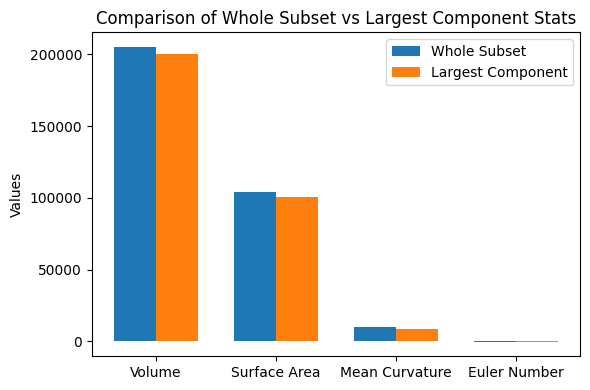

In [9]:
from dpm_tools.metrics import minkowski_functionals

# Whole subset:
whole_volume = minkowski_functionals(sample_subset)[0]
whole_surface_area = minkowski_functionals(sample_subset)[1]
whole_mean_curvature = minkowski_functionals(sample_subset)[2]
whole_euler_number = minkowski_functionals(sample_subset)[3]


# Extracted largest component:
# We set the label of the largest component to 1 for using minowski_functionals:
extracted_largest_component_image = np.where(extracted_largest_component_image == largest_label, 1, 0)

largest_volume = minkowski_functionals(extracted_largest_component_image)[0]
largest_surface_area = minkowski_functionals(extracted_largest_component_image)[1]
largest_mean_curvature = minkowski_functionals(extracted_largest_component_image)[2]
largest_euler_number = minkowski_functionals(extracted_largest_component_image)[3]

# Define whole stats and largest stats
whole_stats = [whole_volume, whole_surface_area, whole_mean_curvature, whole_euler_number]
largest_stats = [largest_volume, largest_surface_area, largest_mean_curvature, largest_euler_number]

# Round the stats to 2 decimals
whole_stats = list(map(lambda x: round(x, 2), whole_stats))
# largest_stats = list(map(lambda x: round(x, 2), largest_stats))

# Print the comparison of whole stats vs largest stats
comparison_df = pd.DataFrame({
    'Stat': ['Volume', 'Surface Area', 'Mean Curvature', 'Euler Number'],
    'Whole Subset': whole_stats,
    'Largest Component': largest_stats
})

print(comparison_df)

# Plot the comparison
labels = ['Volume', 'Surface Area', 'Mean Curvature', 'Euler Number']
whole_stats = [whole_volume, whole_surface_area, whole_mean_curvature, whole_euler_number]
largest_stats = [largest_volume, largest_surface_area, largest_mean_curvature, largest_euler_number]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(x - width/2, whole_stats, width, label='Whole Subset')
rects2 = ax.bar(x + width/2, largest_stats, width, label='Largest Component')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Values')
ax.set_title('Comparison of Whole Subset vs Largest Component Stats')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

___
*Author:* ***[Çınar Turhan](https://www.linkedin.com/in/cinarturhan/)*** 
___